# ASTR 540 Homework 4 - Ansh Gupta

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join
import astropy.units as u
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"

# Problem 1

In [2]:
# list of Gaia IDs to from Carlin+2018
gaia_ids = np.genfromtxt('ids.txt', dtype='str')

In [3]:
# construct a query to retrieve data for the specified Gaia IDs
query = "SELECT * FROM gaiadr3.gaia_source WHERE source_id IN ({})"\
        .format(','.join(map(str, gaia_ids)))

# query Gaia database
gaia_job = Gaia.launch_job_async(query)
query_table = gaia_job.get_results();

INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
# read in the original table from the Carlin+2018 paper for comparison
carlin_table = Table.read('carlin_table.txt', format='csv')
carlin_table['source_id'] = carlin_table['source_id'].astype(np.int64)
new_table = Table(carlin_table) # make a copy of the Carlin table

In [5]:
# replace DR2 values in the Carlin table with DR3 data, if they exist
for row in new_table:
    # check for objects in the Carlin table that are in DR3
    match_row = query_table['source_id'] == row['source_id']
    if match_row.any():
        # for matching objects, update their info
        row['alpha'] = query_table[match_row]['ra']
        row['delta'] = query_table[match_row]['dec']
        row['mu_alpha*'] = query_table[match_row]['pmra']
        row['mu_alpha*_err'] = query_table[match_row]['pmra_error']
        row['mu_delta'] = query_table[match_row]['pmdec']
        row['mu_delta_err'] = query_table[match_row]['pmdec_error']

In [6]:
# write out the updated table into a latex file
new_table.write('updated_carlin_table.tex', format='latex', overwrite=True)

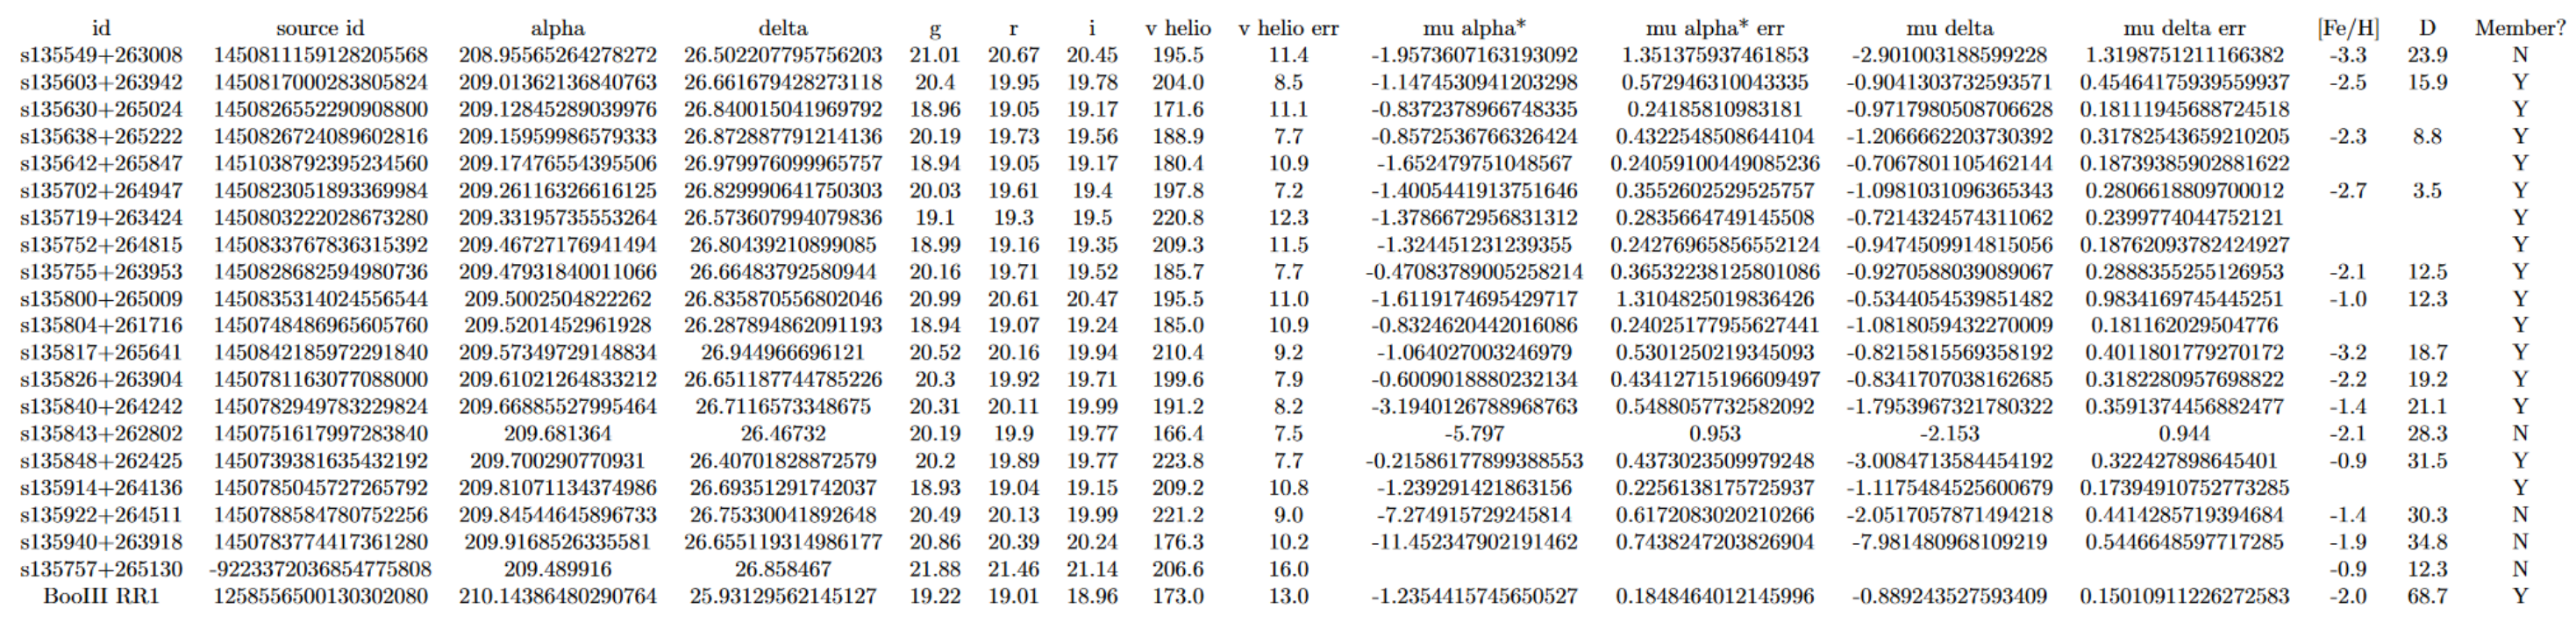
From this table, we see updated proper motion measurements from Gaia DR3 for all but two of the objects from Carlin 2018. The object with ID 1450842185972291840 is not present in DR3, even though it is in DR2 (I confirmed this by checking the same ID by querying Gaia DR2 and I got the expected result). Unfortunately, object -9223372036854775808 is in neither DR2 nor DR3.

In [7]:
# pick out the indices of the objects updated with DR3 data
mask = np.where(np.isin(carlin_table['source_id'], query_table['source_id']))

Average RA PM Error Reduction: 0.475


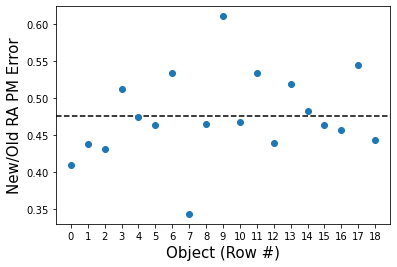

In [8]:
# make a plot which shows the average error reduction in the RA proper motion
alpha_err_ratio = new_table['mu_alpha*_err'][mask]/carlin_table['mu_alpha*_err'][mask]
plt.plot(alpha_err_ratio, 'o')
plt.xlabel('Object (Row #)', fontsize=15)
plt.ylabel('New/Old RA PM Error', fontsize=15)
plt.axhline(np.mean(alpha_err_ratio), ls='--', c='k', zorder=-1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
print(f"Average RA PM Error Reduction: {np.mean(alpha_err_ratio):.3}")

Average RA PM Error Reduction: 0.409


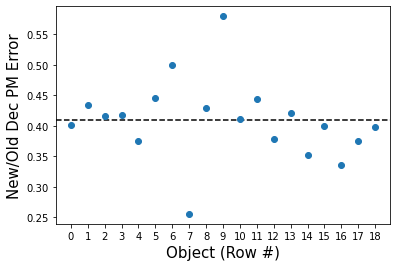

In [9]:
# make a plot which shows the average error reduction in the dec proper motion
delta_err_ratio = new_table['mu_delta_err'][mask]/carlin_table['mu_delta_err'][mask]
plt.plot(delta_err_ratio, 'o')
plt.xlabel('Object (Row #)', fontsize=15)
plt.ylabel('New/Old Dec PM Error', fontsize=15)
plt.axhline(np.mean(delta_err_ratio), ls='--', c='k', zorder=-1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
print(f"Average RA PM Error Reduction: {np.mean(delta_err_ratio):.3}")

From the above two plots, we see that the DR3 measurements cut down the uncertainties on the proper motion values by about half.

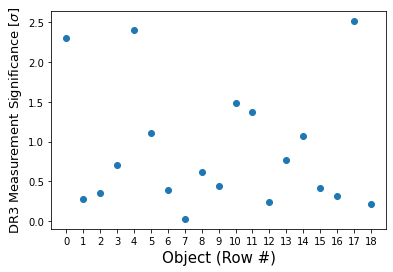

In [10]:
# find the difference (in sigmas) between the new and old measurements
delta_diff = (carlin_table['mu_delta'][mask]-new_table['mu_delta'][mask])
delta_combined_err = np.hypot(carlin_table['mu_delta_err'][mask], new_table['mu_delta_err'][mask])
delta_significance = np.abs(delta_diff/delta_combined_err)
plt.plot(delta_significance, 'o')
plt.xlabel('Object (Row #)', fontsize=15)
plt.ylabel(r'DR3 Measurement Significance [$\sigma$]', fontsize=13)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1));

There are no DR3 measurements that are $>3 \sigma$ away from the originally measured values.

In [11]:
# indices of objects which are labeled as BootesIII members in Carlin+2018
bootes_members = new_table[new_table['Member?'] == 'Y']

In [12]:
# declination since alpha proper motion has a cos(delta) factor
bootes_dec = bootes_members['delta'] * np.pi/180

# measured proper motions and errors of BootesIII RV members
bootes_mu_alpha = bootes_members['mu_alpha*'] * np.cos(bootes_dec)
bootes_mu_alpha_err = bootes_members['mu_alpha*_err'] * np.cos(bootes_dec)
bootes_mu_delta = bootes_members['mu_delta']
bootes_mu_delta_err = bootes_members['mu_delta_err']

In [13]:
# do an error-weighted average to get the proper motions
alpha_weights = 1 / (bootes_mu_alpha_err ** 2)
error_weighted_alpha_mean = np.sum(bootes_mu_alpha * alpha_weights) / np.sum(alpha_weights)
alpha_mean_error = np.sqrt(1 / np.sum(alpha_weights))
delta_weights = 1 / (bootes_mu_delta_err ** 2)
error_weighted_delta_mean = np.sum(bootes_mu_delta * delta_weights) / np.sum(delta_weights)
delta_mean_error = np.sqrt(1 / np.sum(delta_weights))

print(f"Error-weighted Mean RA Proper Motion: {error_weighted_alpha_mean:.3} ± {alpha_mean_error:.1} mas/year")
print(f"Error-weighted Mean Dec Proper Motion: {error_weighted_delta_mean:.3} ± {delta_mean_error:.1} mas/year")

Error-weighted Mean RA Proper Motion: -1.04 ± 0.07 mas/year
Error-weighted Mean Dec Proper Motion: -1.04 ± 0.06 mas/year


The above derived proper motion values are within the uncertainty limits of the values reported in the paper. The dec proper motion is towards the lower end of the range, though. As expected from our previous analysis, the revised uncertainty values are roughly halved compared to those from the paper.

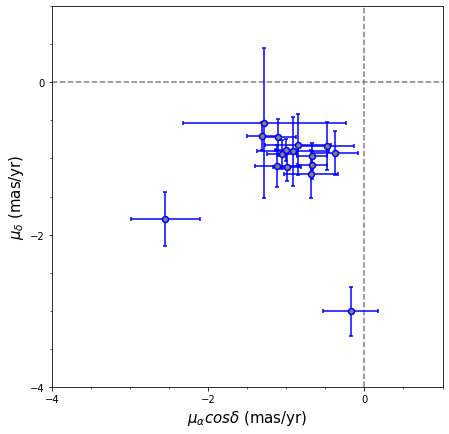

In [14]:
# make a plot similar to Figure 1 from Carlin+2018
plt.figure(figsize=(7, 7))
plt.errorbar(bootes_mu_alpha*np.cos(bootes_dec), bootes_mu_delta, \
             xerr=bootes_mu_alpha_err*np.cos(bootes_dec), yerr=bootes_mu_delta_err, fmt='o',
            markerfacecolor='grey', markeredgecolor='blue', color='blue', capsize=2, lw=1.5,
            markeredgewidth=1.5)
plt.axhline(0, ls='--', c='grey', zorder=-1)
plt.axvline(0, ls='--', c='grey', zorder=-1)

plt.xlim(-4, 1)
plt.ylim(-4, 1)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.5))
plt.xlabel(r'$\mu_{\alpha} cos\delta$ (mas/yr)', fontsize=15)
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=15);

The points in the updated plot appear more tightly clustered than in the original paper, which is good to see and confirms the idea that they belong to a coherent population (the galaxy).

In [15]:
# coordinates for BootesIII center from Grillmair+2009
boo_center_ra = 209.281
boo_center_dec = 26.775

In [16]:
# query all stars within 1 degree of the Bootes center
Gaia.ROW_LIMIT = -1
boo_center = SkyCoord(ra=boo_center_ra, dec=boo_center_dec , unit=(u.degree, u.degree), frame='icrs')
candidate_job = Gaia.cone_search_async(coordinate=boo_center, radius=u.Quantity(1.0, u.degree))
candidate_table = candidate_job.get_results();

INFO: Query finished. [astroquery.utils.tap.core]


In [17]:
# get the measured Gaia radial velocities of stars within 1 deg of Bootes center
candidate_rv = candidate_table['radial_velocity']
candidate_rv_err = candidate_table['radial_velocity_error']

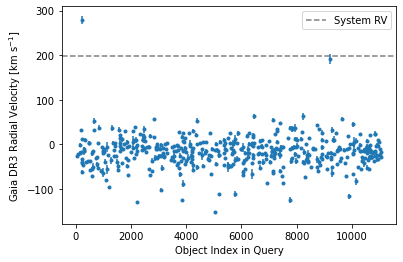

In [18]:
# rough plot to see if any of the stars have RVs consistent with BootesIII
plt.errorbar(np.arange(len(candidate_rv)), candidate_rv, yerr=candidate_rv_err, fmt='o',\
            markersize=3)
plt.axhline(197.5, ls='--', c='grey', zorder=-1, label='System RV')
plt.legend()
plt.xlabel('Object Index in Query')
plt.ylabel(r'Gaia DR3 Radial Velocity [km s$^{-1}$]');

The above plot shows us that only 1 star has a measured RV consistent with that of the system. This is the only plausible BootesIII RV candidate I find using this query/search.

In [19]:
# pick out the index of this star and check its proper motion
RV_candidate_indices = np.where(abs(candidate_rv - 197.5) < candidate_rv_err)
candidate_mu_alpha = candidate_table['pmra']
candidate_mu_delta = candidate_table['pmdec']
print(candidate_mu_alpha[RV_candidate_indices])
print(candidate_mu_delta[RV_candidate_indices])

        pmra       
      mas / yr     
-------------------
-15.236019598334083
       pmdec       
      mas / yr     
-------------------
-1.9254303460750393


Unfortunately, the RA proper motion of this star is far outside those for the stars analyzed earlier. This makes it unlikely to be a true member of this system, and instead might be a contaminant from the nearby disrupting globular cluster NGC 5466. It showed up in my query because I didn't make any color-magnitude cuts, which they applied very strictly in the paper. So I was unable to locate any additional candidate proper motions members of the galaxy.

# Problem 2

In [20]:
# load in the provided data table
dwarf_table = Table.read('rrl.dat', format='ascii')

In [21]:
# extract the quantities from the table
m_i = dwarf_table['i_mag']
m_z = dwarf_table['z_mag']
P = dwarf_table['Period(d)']
Z = 0.0001 # metallicity provided in homework prompt
A_i = dwarf_table['A_i']
A_z = dwarf_table['A_z']

# uncertainty values from the homework prompt
m_i_err = 0.03
m_z_err = 0.03
P_err = 0.01
Z_err = Z*0.1

In [22]:
# apply the equations from Cacares+2008 to get the inferred absolute magnitudes
M_i = 0.908- 1.035*np.log10(P) + 0.220*np.log10(Z)
M_z = 0.839 - 1.295*np.log10(P) + 0.211*np.log10(Z)
# apply error propagation equations to get the uncertanties
M_i_err = (1.035/P)*P_err + (0.220/Z)*Z_err
M_z_err = (1.295/P)*P_err + (0.211/Z)*Z_err

In [23]:
# the only uncertanties are in the distance modulus, so package those up
distmod_i = m_i - M_i
distmod_z = m_z - M_z
distmod_i_err = np.hypot(m_i_err, M_i_err)
distmod_z_err = np.hypot(m_z_err, M_z_err)

# calculate the inferred distance, correcting for extinction
d_i = 10**((distmod_i + 5 - A_i)/5)
d_z = 10**((distmod_z + 5 - A_z)/5)

# propagate error on this distance to get the uncertainty
d_i_err = np.log(10)*d_i*distmod_i_err/5
d_z_err = np.log(10)*d_z*distmod_z_err/5

In [24]:
# average the distance values and add the errors in quadrature
d_combined = np.mean((d_i, d_z), axis=None)
d_combined_err = np.sqrt(np.sum((d_i_err**2, d_z_err**2), axis=None))
print(f'Inferred distance to dwarf galaxy: {d_combined/1000:.4} ± {d_combined_err/1000:.2} kpc')

Inferred distance to dwarf galaxy: 112.6 ± 7.0 kpc
